# Python Fingerprint Example

Python is a flexible and popular language for running data analysis pipelines. In this tutorial we will implement a solution for a fingerprint matching.

## Overview

Fingerprint recognition refers to the automated method for verifying a match between two fingerprints and that is used to identify individuals and verify their identity. Fingerprints (Figure 1) are the most widely used form of biometric used to identify individuals.

![Fingerprints](./fingerprints.png)

The automated fingerprint matching generally required the detection of different fingerprint features (aggregate characteristics of ridges, and minutia points) and then the use of fingerprint matching algorithm, which can do both one-to- one and one-to- many matching operations. Based on the number of matches a proximity score (distance or similarity) can be calculated.

We use the following NIST dataset for the study:

Special Database 14 - NIST Mated Fingerprint Card Pairs 2. (http://www.nist.gov/itl/iad/ig/special_dbases.cfm)



## Objectives

Match the fingerprint images from a probe set to a gallery set and report the match scores.

## Prerequisites

For this work we will use the following algorithms:

- MINDTCT: The NIST minutiae detector, which automatically locates and records ridge ending and bifurcations in a fingerprint image. (http://www.nist.gov/itl/iad/ig/nbis.cfm)
- BOZORTH3: A NIST fingerprint matching algorithm, which is a minutiae based fingerprint-matching algorithm. It can do both one-to- one and one-to- many matching operations. (http://www.nist.gov/itl/iad/ig/nbis.cfm)


In order to follow along, you must have the NBIS tools which provide `mindtct` and `bozorth3` installed. If you are on Ubuntu 16.04 Xenial, the following steps will accomplish this:

```
$ sudo apt-get update -qq
$ sudo apt-get install -y build-essential cmake unzip
$ wget "http://nigos.nist.gov:8080/nist/nbis/nbis_v5_0_0.zip"
$ unzip -d nbis nbis_v5_0_0.zip
$ cd nbis/Rel_5.0.0
$ ./setup.sh /usr/local --without-X11
$ sudo make
```

## Implementation

1. Fetch the fingerprint images from the web
1. Call out to external programs to prepare and compute the match scoreds
1. Store the results in a database
1. Generate a plot to identify  likely matches.

In [1]:
from __future__ import print_function

In [2]:
import urllib
import zipfile
import hashlib

We'll be interacting with the operating system and manipulating files and their pathnames.

In [3]:
import os.path
import os
import sys
import shutil
import tempfile

Some general usefull utilities

In [4]:
import itertools
import functools
import types
from pprint import pprint

Using the `attrs` library provides some nice shortcuts to defining objects

In [5]:
import attr

In [6]:
import sys


We'll be randomly dividing the entire dataset, based on user input, into the probe and gallery stets

In [7]:
import random

We'll need to call out to the NBIS software. We'll also be using multiple processes to take advantage of all the cores on our machine

In [8]:
import subprocess
import multiprocessing

As for plotting, we'll use `matplotlib`, though there are many alternatives.

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Finally, we'll write the results to a database.

In [10]:
import sqlite3

## Utility functions

Next, we'll define some utility functions:

In [11]:
def take(n, iterable):
    "Returns a generator of the first **n** elements of an iterable"
    return itertools.islice(iterable, n )


def zipWith(function, *iterables):
    "Zip a set of **iterables** together and apply **function** to each tuple"
    for group in itertools.izip(*iterables):
        yield function(*group)


def uncurry(function):
    "Transforms an N-arry **function** so that it accepts a single parameter of an N-tuple"
    @functools.wraps(function)
    def wrapper(args):
        return function(*args)
    return wrapper


def fetch_url(url, sha256, prefix='.', checksum_blocksize=2**20, dryRun=False):
    """Download a url.

    :param url: the url to the file on the web
    :param sha256: the SHA-256 checksum. Used to determine if the file was previously downloaded.
    :param prefix: directory to save the file
    :param checksum_blocksize: blocksize to used when computing the checksum
    :param dryRun: boolean indicating that calling this function should do nothing
    :returns: the local path to the downloaded file
    :rtype:

    """

    if not os.path.exists(prefix):
        os.makedirs(prefix)

    local = os.path.join(prefix, os.path.basename(url))

    if dryRun: return local

    if os.path.exists(local):
        print ('Verifying checksum')
        chk = hashlib.sha256()
        with open(local, 'rb') as fd:
            while True:
                bits = fd.read(checksum_blocksize)
                if not bits: break
                chk.update(bits)
        if sha256 == chk.hexdigest():
            return local

    print ('Downloading', url)

    def report(sofar, blocksize, totalsize):
        msg = '{}%\r'.format(100 * sofar * blocksize / totalsize, 100)
        sys.stderr.write(msg)

    urllib.urlretrieve(url, local, report)

    return local


## Dataset

We'll now define some global parameters

First, the fingerprint dataset

In [12]:
DATASET_URL = 'https://s3.amazonaws.com/nist-srd/SD4/NISTSpecialDatabase4GrayScaleImagesofFIGS.zip'
DATASET_SHA256 = '4db6a8f3f9dc14c504180cbf67cdf35167a109280f121c901be37a80ac13c449'

We’ll define how to download the dataset. This function is general enough that it could be used to retrieve most files, but we’ll default it to use the values from above.

In [13]:
def prepare_dataset(url=None, sha256=None, prefix='.', skip=False):
    url = url or DATASET_URL
    sha256 = sha256 or DATASET_SHA256
    local = fetch_url(url, sha256=sha256, prefix=prefix, dryRun=skip)

    if not skip:
        print ('Extracting', local, 'to', prefix)
        with zipfile.ZipFile(local, 'r') as zip:
            zip.extractall(prefix)

    name, _ = os.path.splitext(local)
    return name


def locate_paths(path_md5list, prefix):
    with open(path_md5list) as fd:
        for line in itertools.imap(str.strip, fd):
            parts = line.split()
            if not len(parts) == 2: continue
            md5sum, path = parts
            chksum = Checksum(value=md5sum, kind='md5')
            filepath = os.path.join(prefix, path)
            yield Path(checksum=chksum, filepath=filepath)


def locate_images(paths):

    def predicate(path):
        _, ext = os.path.splitext(path.filepath)
        return ext in ['.png']

    for path in itertools.ifilter(predicate, paths):
        yield image(id=path.checksum.value, path=path)

## Data Model

We'll define some classes so we have a nice API for working with the dataflow. We set `slots=True` so that the resulting objects will be more space-efficient.

### Utilities

#### Checksum

The checksum consists of the actual hash value (`value`) as well as a string representing the hashing algorithm.
The validator enforces that the algorith can only be one of the listed acceptable methods

In [14]:
@attr.s(slots=True)
class Checksum(object):
  value = attr.ib()
  kind = attr.ib(validator=lambda o, a, v: v in 'md5 sha1 sha224 sha256 sha384 sha512'.split())

#### Path

`Path`s refer to an image's filepath and associated `Checksum`. We get the checksum "for "free" since the MD5 hash is provided for each image in the dataset.

In [15]:
@attr.s(slots=True)
class Path(object):
    checksum = attr.ib()
    filepath = attr.ib()


#### Image

The start of the data pipeline is the image. An `image` has an `id` (the md5 hash) and the path to the image.

In [16]:
@attr.s(slots=True)
class image(object):
    id = attr.ib()
    path = attr.ib()

### Mindtct

The next step in the pipeline is to apply the `mindtct` program from NBIS. A `mindtct` object therefore represents the results of applying `mindtct` on an `image`. The `xyt` output is needed fo r the next step, and the `image` attribute represents the image id.

In [17]:
@attr.s(slots=True)
class mindtct(object):
    image = attr.ib()
    xyt = attr.ib()
    
    def pretty(self):
        d = dict(id=self.image.id, path=self.image.path)
        return pprint(d)

We need a way to construct a `mindtct` object from an `image` object. A straightforward way of doing this would be to have a `from_image` `@staticmethod` or `@classmethod`, but that doesn't work well with `multiprocessing` as top-level functions work best as they need to be serialized.

In [18]:
def mindtct_from_image(image):
    imgpath = os.path.abspath(image.path.filepath)
    tempdir = tempfile.mkdtemp()
    oroot = os.path.join(tempdir, 'result')

    cmd = ['mindtct', imgpath, oroot]

    try:
        subprocess.check_call(cmd)

        with open(oroot + '.xyt') as fd:
            xyt = fd.read()

        result = mindtct(image=image.id, xyt=xyt)
        return result

    finally:
        shutil.rmtree(tempdir)


### Bozorth3

The final step in the pipeline is running the `bozorth3` from NBIS. The `bozorth3` class represents the match being done: tracking the ids of the probe and gallery images as well as the match score.

Since we'll be writing these instance out to a database, we provide some static methods for SQL statements. While there are many Object-Relational-Model (ORM) libraries available for Python, this approach keeps the current implementation simple.

In [19]:
@attr.s(slots=True)
class bozorth3(object):
    probe = attr.ib()
    gallery = attr.ib()
    score = attr.ib()
    
    @staticmethod
    def sql_stmt_create_table():
        return 'CREATE TABLE IF NOT EXISTS bozorth3' \
             + '(probe TEXT, gallery TEXT, score NUMERIC)'
        
    @staticmethod
    def sql_prepared_stmt_insert():
        return 'INSERT INTO bozorth3 VALUES (?, ?, ?)'
    
    def sql_prepared_stmt_insert_values(self):
        return self.probe, self.gallery, self.score

In order to work well with `multiprocessing`, we define a class representuing the input paramaters to `bozorth3` and a helper function to run `bozorth3`. This way the pipeline definition can be kept simple to a `map` to create the input and then a `map` to run the program.

As NBIS `bozorth3` can be called to compare one-to-one or one-to-many, we'll also dynamically choose between these approaches depending on if the gallery attribute is a list or a single object.

In [20]:
@attr.s(slots=True)
class bozorth3_input(object):
    probe = attr.ib()
    gallery = attr.ib()
    
    def run(self):
        if isinstance(self.gallery, mindtct):
            return bozorth3_from_one_to_one(self.probe, self.gallery)
        elif isinstance(self.gallery, types.ListType):
            return bozorth3_from_one_to_many(self.probe, self.gallery)
        else:
            raise ValueError('Unhandled type for gallery: {}'.format(type(gallery)))

The next is the top-level function to running `bozorth3`. It accepts an instance of `bozorth3_input`. The is implemented as a simple top-level wrapper so that it can be easily passed to the `multiprocessing` library.

In [21]:
def run_bozorth3(input):
    return input.run()

#### Running Bozorth3

There are two cases to handle:
1. One-to-one probe to gallery sets
1. One-to-many probe to gallery sets

Both approaches are implemented below.
The implementations follow the same pattern:
1. Create a temporary directory within with to work
1. Write the probe and gallery images to files in the temporary directory
1. Call the `bozorth3` executable
1. The match score is written to `stdout` which is captured and then parsed.
1. Return a `bozorth3` instance for each match
1. Make sure to clean up the temporary directory

##### One-to-one

In [22]:
def bozorth3_from_one_to_one(probe, gallery):
    tempdir = tempfile.mkdtemp()
    probeFile = os.path.join(tempdir, 'probe.xyt')
    galleryFile = os.path.join(tempdir, 'gallery.xyt')
    
    with open(probeFile,   'wb') as fd: fd.write(probe.xyt)
    with open(galleryFile, 'wb') as fd: fd.write(gallery.xyt)
        
    cmd = ['bozorth3', probeFile, galleryFile]
    
    try:
        result = subprocess.check_output(cmd)
        score = int(result.strip())
        return bozorth3(probe=probe.image, gallery=gallery.image, score=score)
    finally:
        shutil.rmtree(tempdir)

##### One-to-many

In [23]:
def bozorth3_from_one_to_many(probe, galleryset):
    tempdir = tempfile.mkdtemp()
    probeFile = os.path.join(tempdir, 'probe.xyt')
    galleryFiles = [os.path.join(tempdir, 'gallery%d.xyt' % i)
                    for i,_ in enumerate(galleryset)]
    
    with open(probeFile, 'wb') as fd: fd.write(probe.xyt)
    for galleryFile, gallery in itertools.izip(galleryFiles, galleryset):
        with open(galleryFile, 'wb') as fd: fd.write(gallery.xyt)
            
    cmd = ['bozorth3', '-p', probeFile] + galleryFiles
    
    try:
        result = subprocess.check_output(cmd).strip()
        scores = map(int, result.split('\n'))
        return [bozorth3(probe=probe.image, gallery=gallery.image, score=score)
               for score, gallery in zip(scores, galleryset)]
    finally:
        shutil.rmtree(tempdir)

# Plotting

For plotting we'll operate only on the database. We'll select a small number of probe images and plot the score between them and the rest of the gallery images.

The `mk_short_labels` helper function will be defined below.

In [24]:
def plot(dbfile, nprobes=10):
    conn = sqlite3.connect(dbfile)
    results = pd.read_sql(
        "SELECT DISTINCT probe FROM bozorth3 ORDER BY score LIMIT '%s'" % nprobes,
        con=conn
    )
    shortlabels = mk_short_labels(results.probe)
    plt.figure()
    
    for i, probe in results.probe.iteritems():
        stmt = 'SELECT gallery, score FROM bozorth3 WHERE probe = ? ORDER BY gallery DESC'
        matches = pd.read_sql(stmt, params=(probe,), con=conn)
        xs = np.arange(len(matches), dtype=np.int)
        plt.plot(xs, matches.score, label='probe %s' % shortlabels[i])
        
    plt.ylabel('Score')
    plt.xlabel('Gallery')
    plt.legend(bbox_to_anchor=(0, 0, 1, -0.2))
    plt.show()

The image ids are long hash strings. In ordere to minimize the amount of space on the figure the labels occupy, we provide a helper function to create a short label that still uniquely identifies each probe image in the selected sample

In [25]:
def mk_short_labels(series, start=7):
    for size in xrange(start, len(series[0])):
        if len(series) == len(set(map(lambda s: s[:size], series))):
            break
    return map(lambda s: s[:size], series)

# Putting it all Together

First, set up a temporary directory in which to work:

In [26]:
pool = multiprocessing.Pool()
prefix = '/tmp/fingerprint_example/'
if not os.path.exists(prefix):
    os.makedirs(prefix)

Next we download and extract the fingerprint images from NIST:

In [27]:
%%time
dataprefix = prepare_dataset(prefix=prefix)

Verifying checksum
Extracting /tmp/fingerprint_example/NISTSpecialDatabase4GrayScaleImagesofFIGS.zip to /tmp/fingerprint_example/
CPU times: user 3.34 s, sys: 645 ms, total: 3.99 s
Wall time: 4.01 s


Next we'll configure the location of of the MD5 checksum file that comes with the download

In [28]:
md5listpath = os.path.join(prefix, 'NISTSpecialDatabase4GrayScaleImagesofFIGS/sd04/sd04_md5.lst')

Load the images from the downloaded files to start the analysis pipeline

In [29]:
%%time
print('Loading images')
paths = locate_paths(md5listpath, dataprefix)
images = locate_images(paths)
mindtcts = pool.map(mindtct_from_image, images)
print('Done')

Loading images
Done
CPU times: user 187 ms, sys: 17 ms, total: 204 ms
Wall time: 1min 21s


We can examine one of the loaded image. Note that `image` is refers to the MD5 checksum that came with the image and the `xyt` attribute represents the raw image data.

In [30]:
print(mindtcts[0].image)
print(mindtcts[0].xyt[:50])

98b15d56330cb17f1982ae79348f711d
14 146 214 6
25 238 22 37
25 51 180 20
30 332 214 


For example purposes we'll only a use a small percentage of the database, randomly selected, for pur probe and gallery datasets.

In [39]:
perc_probe = 0.001
perc_gallery = 0.1

In [40]:
%%time
print('Generating samples')
probes  = random.sample(mindtcts, int(perc_probe   * len(mindtcts)))
gallery = random.sample(mindtcts, int(perc_gallery * len(mindtcts)))
print('|Probes| =', len(probes))
print('|Gallery|=', len(gallery))

Generating samples
|Probes| = 4
|Gallery|= 400
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 993 µs


We can now compute the matching scores between the probe and gallery sets.
This will use all cores available on this workstation.

In [41]:
%%time
print('Matching')
input = [bozorth3_input(probe=probe, gallery=gallery)
         for probe in probes]
bozorth3s = pool.map(run_bozorth3, input)

Matching
CPU times: user 19 ms, sys: 1 ms, total: 20 ms
Wall time: 1.07 s


`bozorth3s` is now a `list` of `lists` of `bozorth3` instances.

In [42]:
print('|Probes|  =', len(bozorth3s))
print('|Gallery| =', len(bozorth3s[0]))
print('Result:', bozorth3s[0][0])

|Probes|  = 4
|Gallery| = 400
Result: bozorth3(probe='caf9143b268701416fbed6a9eb2eb4cf', gallery='22fa0f24998eaea39dea152e4a73f267', score=4)


Now add the results to the database

In [43]:
dbfile = os.path.join(prefix, 'scores.db')
conn = sqlite3.connect(dbfile)
cursor = conn.cursor()
cursor.execute(bozorth3.sql_stmt_create_table())

In [44]:
%%time
for group in bozorth3s:
    vals = map(bozorth3.sql_prepared_stmt_insert_values, group)
    cursor.executemany(bozorth3.sql_prepared_stmt_insert(), vals)
    conn.commit()
    print('Inserted results for probe', group[0].probe)

Inserted results for probe caf9143b268701416fbed6a9eb2eb4cf
Inserted results for probe 55ac57f711eba081b9302eab74dea88e
Inserted results for probe 4ed2d53db3b5ab7d6b216ea0314beb4f
Inserted results for probe 20f68849ee2dad02b8fb33ecd3ece507
CPU times: user 2 ms, sys: 3 ms, total: 5 ms
Wall time: 3.57 ms


We now plot the results.

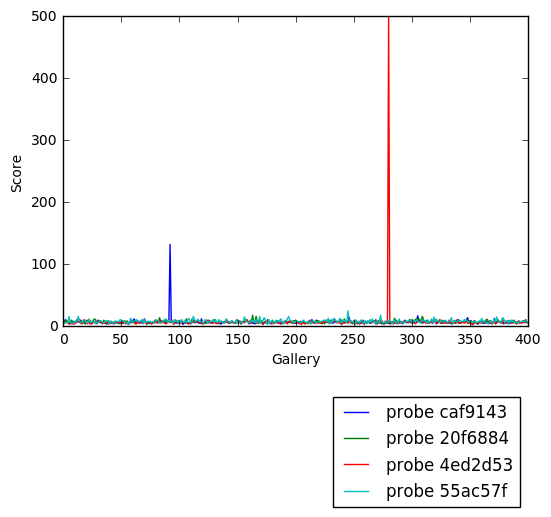

In [45]:
plot(dbfile, nprobes=len(probes))

In [46]:
cursor.close()